In [1]:
%load_ext autoreload
%autoreload 2

import sys 
from os import getcwd, path
sys.path.append(path.dirname(getcwd()))
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
import pprint
from cohorts.functions import *
import lifelines as ll
import patsy
import functools
import survivalstan
from cohorts.utils import strip_column_names
import scipy
%matplotlib inline


In [2]:
## set seeds for stan & rngs, to aid in reproducibility
## (note: only reproducible within a machine, not across machines)

seed = 91038753
import random
random.seed(seed)

In [3]:
from utils import data
import scipy
from utils import paper
from utils.extra_functions import *

# prep data 

## load data

In [4]:
cohort = data.init_cohort(join_with=["ensembl_coverage","tcr_peripheral_a"])

inner join with tcr_peripheral_a: 25 to 25 rows
inner join with ensembl_coverage: 25 to 25 rows


inner join with tcr_peripheral_a: 25 to 25 rows
inner join with ensembl_coverage: 25 to 25 rows
{'dataframe_hash': 7698303973572390439,
 'provenance_file_summary': {u'cohorts': u'0.4.0+3.gda968fb',
                             u'isovar': u'0.0.6',
                             u'mhctools': u'0.3.0',
                             u'numpy': u'1.11.1',
                             u'pandas': u'0.18.1',
                             u'pyensembl': u'1.0.3',
                             u'scipy': u'0.18.1',
                             u'topiary': u'0.1.0',
                             u'varcode': u'0.5.10'}}


In [5]:
def tcell_fraction(row):
    return row["T-cell fraction"]

def peripheral_clonality_a(row):
    return row['Clonality']

cols, d = cohort.as_dataframe([snv_count,
                               missense_snv_count,
                               neoantigen_count,
                               expressed_exonic_snv_count,
                               expressed_missense_snv_count,
                               expressed_neoantigen_count,
                               exonic_snv_count,
                               peripheral_clonality_a,
                               tcell_fraction,
                               ],
                              rename_cols=True,
                              return_cols=True)

inner join with tcr_peripheral_a: 25 to 25 rows
inner join with ensembl_coverage: 25 to 25 rows


inner join with ensembl_coverage: 25 to 25 rows


In [6]:
cols

['snv_count',
 'missense_snv_count',
 'neoantigen_count',
 'expressed_exonic_snv_count',
 'expressed_missense_snv_count',
 'expressed_neoantigen_count',
 'exonic_snv_count',
 'peripheral_clonality_a',
 'tcell_fraction']

## construct/rescale variables

In [7]:
## add/modify count variables
d['nonexonic_snv_count'] = d.snv_count - d.exonic_snv_count
cols.append('nonexonic_snv_count')

In [8]:
## create 'observed', log-transformed & centered versions of variables (not normalized by MB)
for col in cols:
    observed_col = 'observed_{}'.format(col)
    log_col = 'log_{}'.format(col)
    log_col_centered = 'log_{}_centered'.format(col)
    log_col_rescaled = 'log_{}_rescaled'.format(col)
    d[observed_col] = d[col]*d['mb']
    d[log_col] = np.log1p(d[observed_col])
    d[log_col_centered] = d[log_col] - np.mean(d[log_col])
    d[log_col_rescaled] = d[log_col_centered]/np.std(d[log_col_centered])

## save key vars in list for future use
vars_centered = ['log_{}_centered'.format(col) for col in cols]
vars_rescaled = ['log_{}_rescaled'.format(col) for col in cols]

In [9]:
## construct new variables for key ratios / comparisons

# what proportion of X are expressed?
d['exonic_expression_ratio'] = d.expressed_exonic_snv_count / d.exonic_snv_count
d['missense_expression_ratio'] = d.expressed_missense_snv_count / d.missense_snv_count
d['neoantigen_expression_ratio'] = d.expressed_neoantigen_count / d.neoantigen_count

# d['expressed_missense2snv_ratio'] = d.expressed_missense_snv_count / d.expressed_snv_count
d['missense2exonic_snv_ratio'] = d.missense_snv_count / d.exonic_snv_count
d['expressed_neoantigen2missense_ratio'] = d.expressed_neoantigen_count / d.expressed_missense_snv_count

extra_cols = ['missense_expression_ratio','neoantigen_expression_ratio', 'exonic_expression_ratio', 'missense2exonic_snv_ratio','expressed_neoantigen2missense_ratio']
## create recentered versions of ratios
for col in extra_cols:
    col_centered = '{}_centered'.format(col)
    col_rescaled = '{}_rescaled'.format(col)
    d[col_centered] = d[col] - np.mean(d[col])
    d[col_rescaled] = d[col_centered]/np.std(d[col_centered])

## append extra-cols to key var lists
vars_centered.extend(['{}_centered'.format(col) for col in extra_cols])
vars_rescaled.extend(['{}_rescaled'.format(col) for col in extra_cols])


## center variables by mean within PD-L1 group

In [10]:
## center variables by group
metrics = list(cols)
metrics.extend(extra_cols)


In [11]:
metrics2 = list(metrics)
metrics2.extend(['pd_l1'])
assert(not 'pd_l1' in metrics)


In [12]:
bygrp = d.loc[:, metrics2]
bygrp = bygrp.groupby('pd_l1').transform(lambda x: x - x.mean())
bygrp['patient_id'] = d.patient_id

In [13]:
df = pd.merge(d, bygrp, on = 'patient_id', suffixes = ['', '_centered_by_pd_l1'])

In [14]:
#df.head()

# univariate survival analysis of revised metrics

In [15]:
## prep dflong_pfs which will be used for survival analysis using stan
df_long_pfs = survivalstan.prep_data_long_surv(df = df, event_col = 'is_progressed_or_deceased', time_col = 'pfs')
df_long_os = survivalstan.prep_data_long_surv(df = df, event_col = 'is_deceased', time_col = 'os')

In [16]:
def extract_univariate_coefdata(model_list, metrics=None):
    coefdata = list()
    [coefdata.append(model['coefs']) for model in model_list]
    coefdata = pd.concat(coefdata)
    coefdata['expressed'] = coefdata.variable.str.contains('expressed')
    coefdata['metric'] = coefdata.variable.str.replace('expressed_','').str.replace('log_','').str.replace('_centered','')
    coefdata['ratio'] = coefdata.variable.str.contains('ratio')
    coefdata['Odds Ratio'] = np.exp(coefdata.value)
    coefdata['is_expressed'] = coefdata.expressed.apply(lambda x: 'expressed variants' if x==True else 'all variants')
    if metrics:
        coefdata = coefdata.loc[coefdata.metric.isin(metrics),:]
    else:
        coefdata = coefdata.loc[coefdata.ratio == False,:]
    return(coefdata)

def univariate_coefplot(model_list, metrics=None, hue='is_expressed'):
    coefdata = extract_univariate_coefdata(model_list=model_list, metrics=metrics)
    sb.boxplot(data=coefdata, x='Odds Ratio', y='metric', hue=hue, fliersize=0, whis=[2.5, 97.5],)
    plt.xlim([0, 4])
    plt.vlines(x=1, ymin=-10, ymax=10, linestyles='--')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return(coefdata)


## using unstructured hazard

In [17]:
survstan_pfs = functools.partial(
    survivalstan.fit_stan_survival_model,
    df = df_long_pfs,
    model_code = survivalstan.models.pem_survival_model_unstructured,
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    sample_col = 'patient_id',
    chains = 4,
    iter = 10000,
    seed = seed,
    )

survstan_os = functools.partial(
    survivalstan.fit_stan_survival_model,
    df = df_long_os,
    model_code = survivalstan.models.pem_survival_model_unstructured,
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    sample_col = 'patient_id',
    chains = 4,
    iter = 10000,
    seed = seed,
    )


## analysis of PFS

In [18]:
univariate_models = list()
for var in vars_centered:
    univariate_models.append(survstan_pfs(formula = var, model_cohort = 'univariate survival analysis for PFS, unstructured hazard'))


NOT reusing model.


Ran in 60.963 sec.


/home/tavi/miniconda2/lib/python2.7/site-packages/stanity/psis.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif sort == 'in-place':
/home/tavi/miniconda2/lib/python2.7/site-packages/stanity/psis.py:246: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  bs /= 3 * x[sort[np.floor(n/4 + 0.5) - 1]]


Reusing model.


Ran in 19.609 sec.


Reusing model.


Ran in 12.977 sec.


Reusing model.


Ran in 13.439 sec.


Reusing model.


Ran in 14.603 sec.


Reusing model.


Ran in 15.573 sec.


Reusing model.


Ran in 19.176 sec.


Reusing model.


Ran in 13.285 sec.


Reusing model.


Ran in 15.681 sec.


Reusing model.


Ran in 16.408 sec.


Reusing model.


Ran in 16.875 sec.


Reusing model.


Ran in 16.543 sec.


Reusing model.


Ran in 15.677 sec.


Reusing model.


Ran in 15.983 sec.


Reusing model.


Ran in 11.649 sec.


{{{univariate-metrics-pfs-all}}}


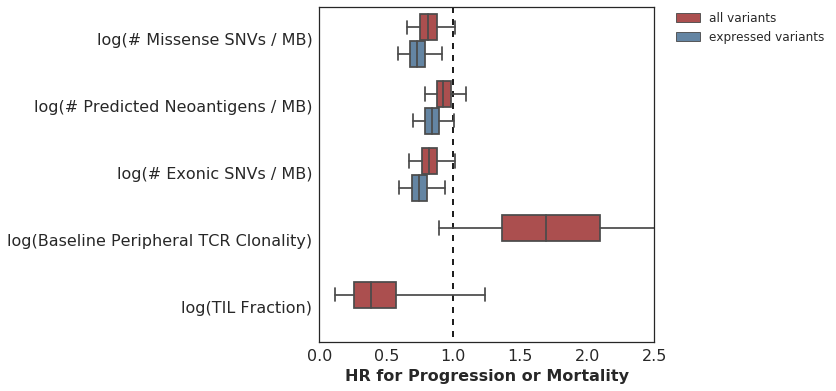

In [19]:
print('{{{univariate-metrics-pfs-all}}}')
coefdata = univariate_coefplot(univariate_models,
                              metrics=['missense_snv_count',
                                       'exonic_snv_count',
                                       'neoantigen_count',
                                       'peripheral_clonality_a',
                                       'tcell_fraction',
                                      ])
_ = plt.xlim([0, 2.5])
_ = plt.yticks([0, 1, 2, 3, 4],
               ['log(# Missense SNVs / MB)',
                'log(# Predicted Neoantigens / MB)',
                'log(# Exonic SNVs / MB)',
                'log(Baseline Peripheral TCR Clonality)',
                'log(TIL Fraction)',
               ])
_ = plt.ylabel('')
_ = plt.xlabel('HR for {}'.format(cohort.hazard_plot_name))

{{{univariate-metrics-pfs}}}


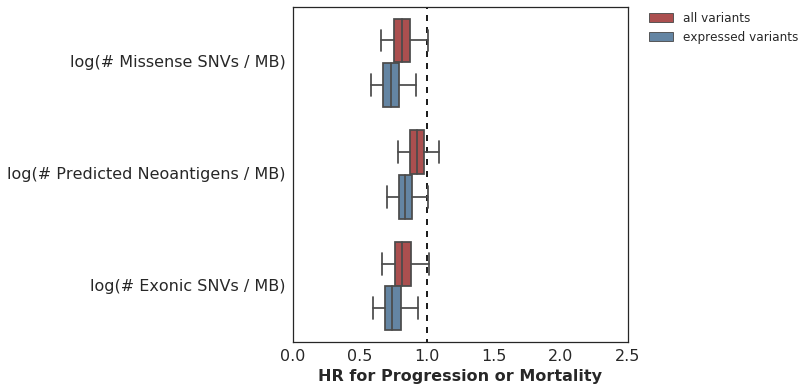

In [20]:
print('{{{univariate-metrics-pfs}}}')
coefdata = univariate_coefplot(univariate_models,
                               metrics=['missense_snv_count','exonic_snv_count','neoantigen_count'])
_ = plt.xlim([0, 2.5])
_ = plt.yticks([0, 1, 2],
               ['log(# Missense SNVs / MB)',
                'log(# Predicted Neoantigens / MB)',
                'log(# Exonic SNVs / MB)',
               ])
_ = plt.ylabel('')
_ = plt.xlabel('HR for {}'.format(cohort.hazard_plot_name))

Compare distribution of posterior draws for expressed vs total variant counts

{{{univariate-ratios-pfs}}}


/home/tavi/miniconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


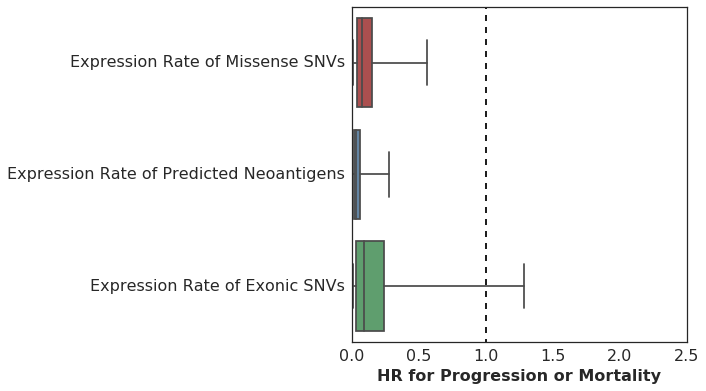

In [21]:
## look at expression ratios, separately
print('{{{univariate-ratios-pfs}}}')
coefdata = univariate_coefplot(univariate_models,
                               metrics=[x for x in extra_cols if 'expression_ratio' in x], hue=None)
_ = plt.xlim([0, 2.5])
_ = plt.yticks([0, 1, 2],
               ['Expression Rate of Missense SNVs',
                'Expression Rate of Predicted Neoantigens',
                'Expression Rate of Exonic SNVs',
                 ])
_ = plt.ylabel('')
_ = plt.xlabel('HR for {}'.format(cohort.hazard_plot_name))

{{{univariate-ratios-pfs-original}}}


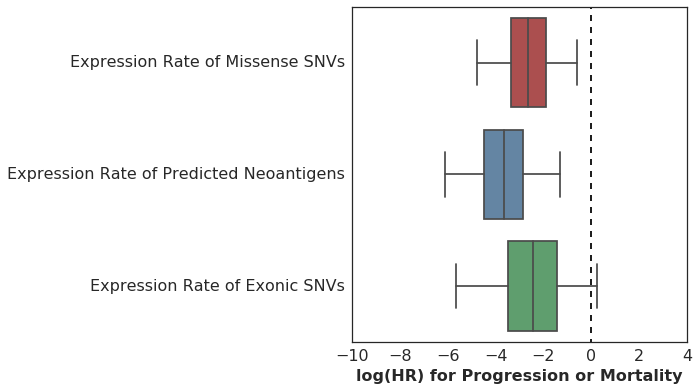

In [22]:
## look at expression ratios, separately
## on original scale 
coefdata = univariate_coefplot(univariate_models,
                               metrics=[x for x in extra_cols if 'expression_ratio' in x],
                               hue=None)
plt.close()
print('{{{univariate-ratios-pfs-original}}}')
sb.boxplot(data=coefdata,
           x='value',
           y='metric',
           fliersize=0, whis=[2.5, 97.5])
_ = plt.vlines(x=0, ymin=-10, ymax=10, linestyles='--')
_ = plt.yticks([0, 1, 2],
               ['Expression Rate of Missense SNVs',
                'Expression Rate of Predicted Neoantigens',
                'Expression Rate of Exonic SNVs',
                 ])
_ = plt.ylabel('')
_ = plt.xlabel('log(HR) for {}'.format(cohort.hazard_plot_name))

In [23]:
univariate_pfs_coefdata = extract_univariate_coefdata(univariate_models,
                                                 metrics=['missense_snv_count','exonic_snv_count','neoantigen_count']
                                                 )


coefdata_pfs_grouped = univariate_pfs_coefdata.groupby('metric')
for name, group in coefdata_pfs_grouped:
    hyper_label='compare_%s_pfs' % name
    paper.hyper_label_printer(label=hyper_label, formatter=paper.compare_posterior_dist, df=group)

{{{compare_exonic_snv_count_pfs:median HR of 0.75 vs. 0.82 for expressed versus total}}}
{{{compare_missense_snv_count_pfs:median HR of 0.73 vs. 0.81 for expressed versus total}}}
{{{compare_neoantigen_count_pfs:median HR of 0.84 vs. 0.93 for expressed versus total}}}


## analysis of OS 

In [24]:
univariate_os_models = list()
for var in vars_centered:
    univariate_os_models.append(survstan_os(formula = var, model_cohort = 'univariate survival analysis for OS, unstructured hazard'))


Reusing model.


Ran in 22.390 sec.


Reusing model.


Ran in 19.371 sec.


Reusing model.


Ran in 21.278 sec.


Reusing model.


Ran in 22.475 sec.


Reusing model.


Ran in 29.977 sec.


Reusing model.


Ran in 20.460 sec.


Reusing model.


Ran in 21.339 sec.


Reusing model.


Ran in 22.168 sec.


Reusing model.


Ran in 21.674 sec.


Reusing model.


Ran in 19.907 sec.


Reusing model.


Ran in 29.093 sec.


Reusing model.


Ran in 22.110 sec.


Reusing model.


Ran in 27.347 sec.


Reusing model.


Ran in 20.193 sec.


Reusing model.


Ran in 20.868 sec.


{{{univariate-metrics-os-all}}}


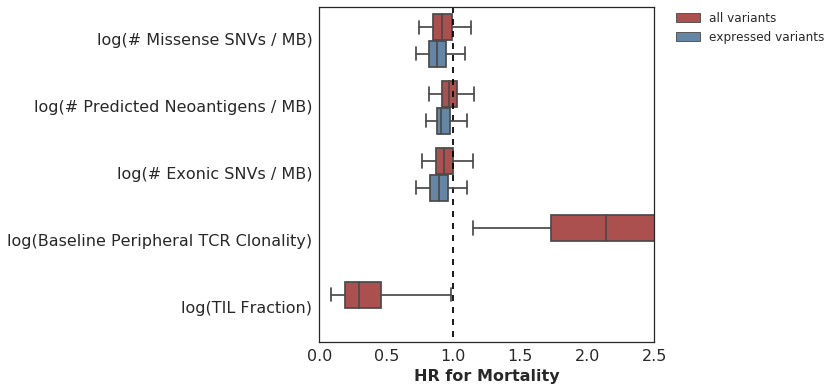

In [25]:
print('{{{univariate-metrics-os-all}}}')
coefdata = univariate_coefplot(univariate_os_models,
                              metrics=['missense_snv_count',
                                       'exonic_snv_count',
                                       'neoantigen_count',
                                       'peripheral_clonality_a',
                                       'tcell_fraction',
                                      ])
_ = plt.xlim([0, 2.5])
_ = plt.yticks([0, 1, 2, 3, 4],
               ['log(# Missense SNVs / MB)',
                'log(# Predicted Neoantigens / MB)',
                'log(# Exonic SNVs / MB)',
                'log(Baseline Peripheral TCR Clonality)',
                'log(TIL Fraction)',
               ])
_ = plt.ylabel('')
_ = plt.xlabel('HR for {}'.format(cohort.hazard_os_plot_name))

{{{univariate-metrics-os}}}


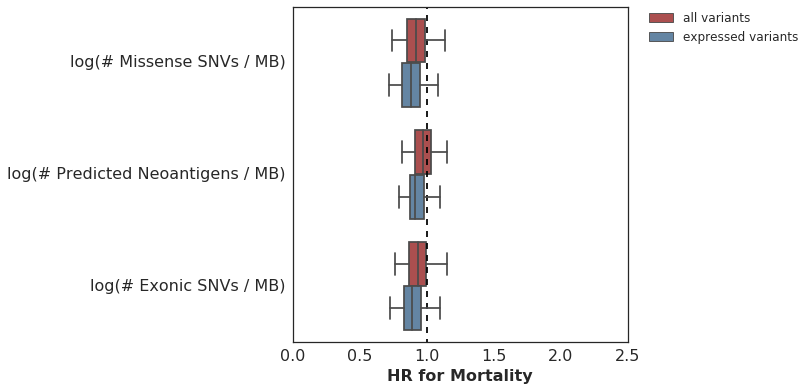

In [26]:
print('{{{univariate-metrics-os}}}')
coefdata = univariate_coefplot(univariate_os_models,
                               metrics=['missense_snv_count','exonic_snv_count','neoantigen_count'])
_ = plt.xlim([0, 2.5])
_ = plt.yticks([0, 1, 2],
               ['log(# Missense SNVs / MB)',
                'log(# Predicted Neoantigens / MB)',
                'log(# Exonic SNVs / MB)',
               ])
_ = plt.ylabel('')
_ = plt.xlabel('HR for {}'.format(cohort.hazard_os_plot_name))

{{{univariate-ratios-os}}}


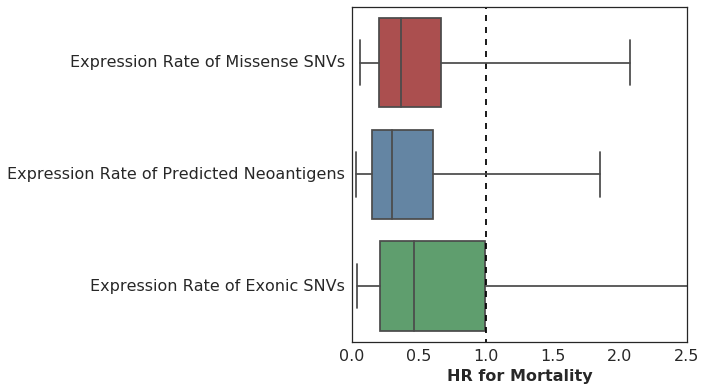

In [27]:
## look at expression ratios
print('{{{univariate-ratios-os}}}')
coefdata = univariate_coefplot(univariate_os_models,
                               metrics=[x for x in extra_cols if 'expression_ratio' in x], hue=None)
_ = plt.xlim([0, 2.5])
_ = plt.yticks([0, 1, 2],
               ['Expression Rate of Missense SNVs',
                'Expression Rate of Predicted Neoantigens',
                'Expression Rate of Exonic SNVs',
                 ])
_ = plt.ylabel('')
_ = plt.xlabel('HR for {}'.format(cohort.hazard_os_plot_name))

{{{univariate-ratios-os-original}}}


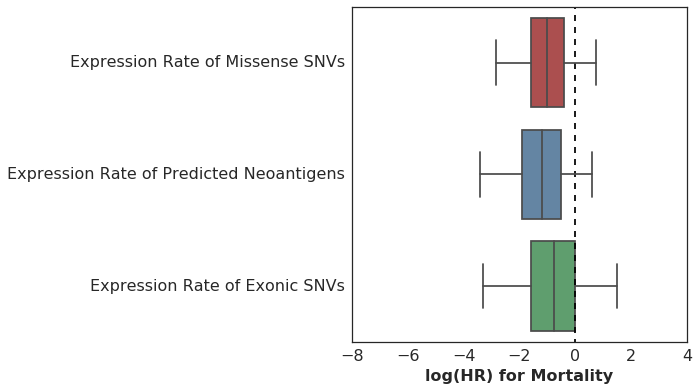

In [28]:
## look at expression ratios, separately
## on original scale 
coefdata = univariate_coefplot(univariate_os_models,
                               metrics=[x for x in extra_cols if 'expression_ratio' in x],
                               hue=None)
plt.close()
print('{{{univariate-ratios-os-original}}}')
sb.boxplot(data=coefdata,
           x='value',
           y='metric',
           fliersize=0, whis=[2.5, 97.5])
_ = plt.vlines(x=0, ymin=-10, ymax=10, linestyles='--')
_ = plt.yticks([0, 1, 2],
               ['Expression Rate of Missense SNVs',
                'Expression Rate of Predicted Neoantigens',
                'Expression Rate of Exonic SNVs',
                 ])
_ = plt.ylabel('')
_ = plt.xlabel('log(HR) for {}'.format(cohort.hazard_os_plot_name))

In [29]:
univariate_os_coefdata = extract_univariate_coefdata(univariate_os_models,
                                                 metrics=['missense_snv_count','exonic_snv_count','neoantigen_count']
                                                 )


coefdata_os_grouped = univariate_os_coefdata.groupby('metric')
for name, group in coefdata_os_grouped:
    hyper_label='compare_%s_os' % name
    paper.hyper_label_printer(label=hyper_label, formatter=paper.compare_posterior_dist, df=group)

{{{compare_exonic_snv_count_os:median HR of 0.89 vs. 0.93 for expressed versus total}}}
{{{compare_missense_snv_count_os:median HR of 0.88 vs. 0.92 for expressed versus total}}}
{{{compare_neoantigen_count_os:median HR of 0.91 vs. 0.97 for expressed versus total}}}


# univariate logistic analysis of revised metrics

In [30]:
models = survivalstan.utils.read_files('../utils/stan')

../utils/stan/logistic_model.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_expressed_missense_and_neoant_mutations.stan
../utils/stan/logistic_model_by_group.stan
../utils/stan/pem_survival_model_unstructured_varcoef.stan
../utils/stan/pem_survival_model_unstructured_varcoef_hsprior.stan
../utils/stan/pem_survival_model_randomwalk_tvc.stan
../utils/stan/pem_survival_model_randomwalk_alt.stan
../utils/stan/pem_survival_model_randomwalk_bspline_est_xi.stan
../utils/stan/pem_survival_model_varying_coefs3.stan
../utils/stan/pem_survival_model_randomwalk.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_rate_only.stan
../utils/stan/pem_survival_model_gamma.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_missense_and_neoant_rates.stan
../utils/stan/pem_survival_model_randomwalk_tvc2.stan
../utils/stan/pem_survival_model_varying_coefs2.stan
../utils/stan/pem_survival_model_varying_coefs4.stan
../utils/stan/pem_survival_model_randomwalk_bspline_est_xi2

In [31]:
logit_pfs = functools.partial(
    survivalstan.fit_stan_survival_model,
    df = df,
    model_code = models['logistic_model.stan'],
    time_col = 'pfs', # not used, included for consistency
    event_col = 'is_benefit',
    chains = 4,
    iter = 10000,
    seed = seed,
    )
logit_os = functools.partial(
    survivalstan.fit_stan_survival_model,
    df = df,
    model_code = models['logistic_model.stan'],
    time_col = 'os', # not used, included for consistency
    event_col = 'is_benefit_os',
    chains = 4,
    iter = 10000,
    seed = seed,
    )

In [32]:
#test_model = logit_pfs(formula = '~ missense_snv_count', model_cohort = 'test model')
#survivalstan.utils.plot_coefs([test_model])

## analysis for DCB using PFS

In [33]:
univariate_logit_models = list()
for var in vars_centered:
    univariate_logit_models.append(logit_pfs(formula = var, model_cohort = 'univariate logit model for PFS-benefit'))


NOT reusing model.


Ran in 48.878 sec.


Reusing model.


Ran in 2.889 sec.


Reusing model.


Ran in 2.630 sec.


Reusing model.


Ran in 2.907 sec.


Reusing model.


Ran in 2.946 sec.


Reusing model.


Ran in 2.947 sec.


Reusing model.


Ran in 2.865 sec.


Reusing model.


Ran in 2.896 sec.


Reusing model.


Ran in 3.065 sec.


Reusing model.


Ran in 2.975 sec.


Reusing model.


Ran in 2.673 sec.


Reusing model.


Ran in 2.740 sec.


Reusing model.


Ran in 2.930 sec.


Reusing model.


Ran in 2.845 sec.


Reusing model.


Ran in 3.130 sec.


In [34]:
#survivalstan.utils.plot_coefs(univariate_logit_models)

{{{coefplot-dcb-pfs2}}}


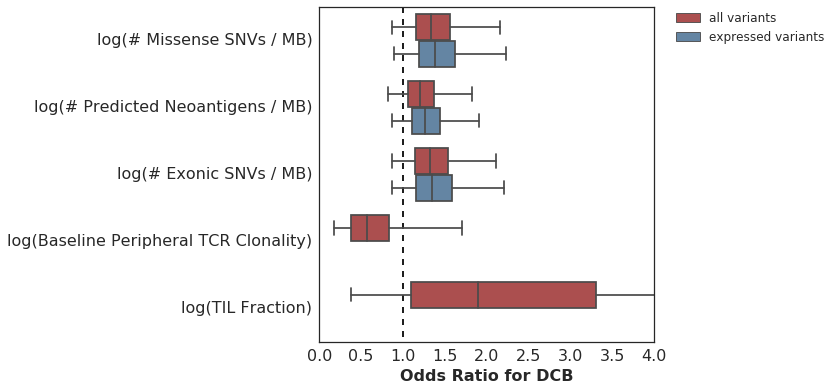

In [35]:
print('{{{coefplot-dcb-pfs2}}}')
coefdata = univariate_coefplot(univariate_logit_models,
                               metrics=['missense_snv_count','exonic_snv_count',
                                        'neoantigen_count','peripheral_clonality_a',
                                        'tcell_fraction',
                                       ])
_ = plt.yticks([0, 1, 2, 3, 4],
               ['log(# Missense SNVs / MB)',
                'log(# Predicted Neoantigens / MB)',
                'log(# Exonic SNVs / MB)',
                'log(Baseline Peripheral TCR Clonality)',
                'log(TIL Fraction)',
               ])
_ = plt.ylabel('')
_ = plt.xlabel('Odds Ratio for {}'.format(cohort.benefit_plot_name))

{{{coefplot-dcb-pfs}}}


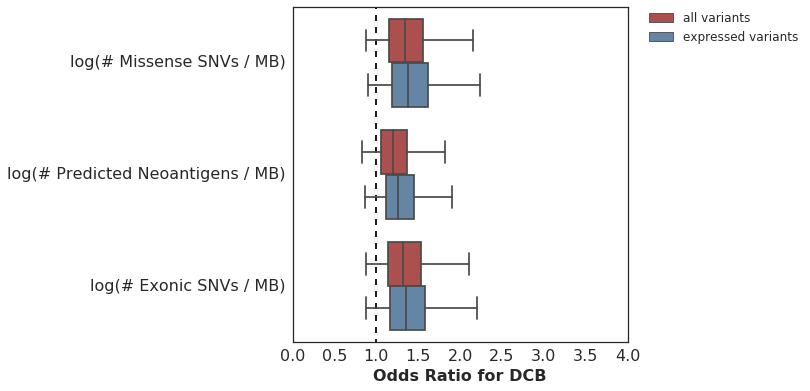

In [36]:
print('{{{coefplot-dcb-pfs}}}')
coefdata = univariate_coefplot(univariate_logit_models,
                               metrics=['missense_snv_count','exonic_snv_count',
                                        'neoantigen_count'])
_ = plt.yticks([0, 1, 2],
               ['log(# Missense SNVs / MB)',
                'log(# Predicted Neoantigens / MB)',
                'log(# Exonic SNVs / MB)',
                 ])
_ = plt.ylabel('')
_ = plt.xlabel('Odds Ratio for {}'.format(cohort.benefit_plot_name))

In [37]:
univariate_logit_dcb_coefdata = extract_univariate_coefdata(univariate_logit_models,
                                                 metrics=['missense_snv_count','exonic_snv_count','neoantigen_count']
                                                 )


coefdata_logit_dcb_grouped = univariate_logit_dcb_coefdata.groupby('metric')
for name, group in coefdata_logit_dcb_grouped:
    hyper_label='compare_%s_logit_dcb' % name
    paper.hyper_label_printer(label=hyper_label, formatter=paper.compare_posterior_dist, df=group, stat='OR')

{{{compare_exonic_snv_count_logit_dcb:median OR of 1.35 vs. 1.32 for expressed versus total}}}
{{{compare_missense_snv_count_logit_dcb:median OR of 1.38 vs. 1.34 for expressed versus total}}}
{{{compare_neoantigen_count_logit_dcb:median OR of 1.26 vs. 1.20 for expressed versus total}}}


{{{coefplot-ratios-dcb-pfs}}}


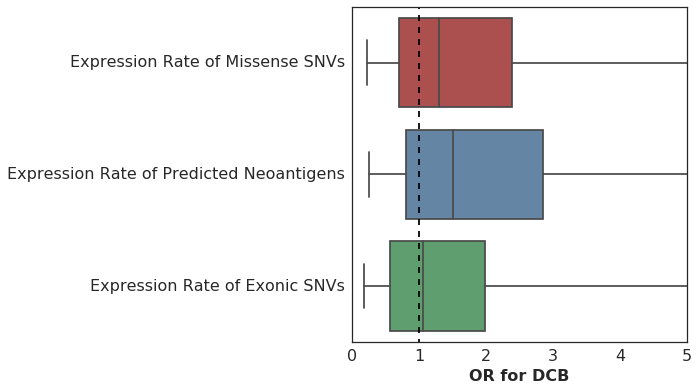

In [38]:
## look at expression ratios, separately
print('{{{coefplot-ratios-dcb-pfs}}}')

coefdata = univariate_coefplot(univariate_logit_models,
                               metrics=[x for x in extra_cols if 'expression_ratio' in x],
                               hue=None)
_ = plt.xlim([0, 5])
_ = plt.yticks([0, 1, 2],
               ['Expression Rate of Missense SNVs',
                'Expression Rate of Predicted Neoantigens',
                'Expression Rate of Exonic SNVs',
                 ])
_ = plt.ylabel('')
_ = plt.xlabel('OR for {}'.format(cohort.benefit_plot_name))

In [39]:
univariate_logit_dcb_coefdata2 = extract_univariate_coefdata(univariate_logit_models,
                                                 metrics=[x for x in extra_cols if 'expression_ratio' in x]
                                                 )


coefdata_logit_dcb_grouped2 = univariate_logit_dcb_coefdata2.groupby('metric')
for name, group in coefdata_logit_dcb_grouped2:
    hyper_label='summary_%s_logit_dcb' % name
    paper.hyper_label_printer(label=hyper_label, formatter=paper.hr_posterior_formatter, series=group['exp(beta)'], stat='OR')

{{{summary_exonic_expression_ratio_logit_dcb:OR=1.64, 95% CI (0.17, 6.77)}}}
{{{summary_missense_expression_ratio_logit_dcb:OR=1.96, 95% CI (0.22, 7.76)}}}
{{{summary_neoantigen_expression_ratio_logit_dcb:OR=2.34, 95% CI (0.25, 9.34)}}}


## analysis for DCB using OS

In [40]:
univariate_logit_models_os = list()
for var in vars_centered:
    univariate_logit_models_os.append(logit_os(formula = var, model_cohort = 'univariate logit model for OS-benefit'))


Reusing model.


Ran in 3.117 sec.


Reusing model.


Ran in 3.045 sec.


Reusing model.


Ran in 2.926 sec.


Reusing model.


Ran in 3.125 sec.


Reusing model.


Ran in 2.806 sec.


Reusing model.


Ran in 2.741 sec.


Reusing model.


Ran in 2.765 sec.


Reusing model.


Ran in 2.880 sec.


Reusing model.


Ran in 2.927 sec.


Reusing model.


Ran in 3.065 sec.


Reusing model.


Ran in 3.142 sec.


Reusing model.


Ran in 3.217 sec.


Reusing model.


Ran in 3.196 sec.


Reusing model.


Ran in 3.153 sec.


Reusing model.


Ran in 3.046 sec.


{{{coefplot-dcb-os2}}}


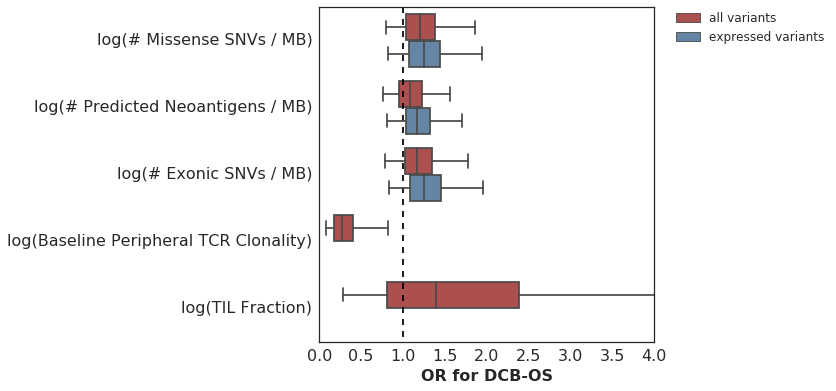

In [41]:
print('{{{coefplot-dcb-os2}}}')
coefdata = univariate_coefplot(univariate_logit_models_os,
                               metrics=['missense_snv_count',
                                        'exonic_snv_count',
                                        'neoantigen_count',
                                        'peripheral_clonality_a',
                                        'tcell_fraction',
                                       ])
_ = plt.yticks([0, 1, 2, 3, 4],
               ['log(# Missense SNVs / MB)',
                'log(# Predicted Neoantigens / MB)',
                'log(# Exonic SNVs / MB)',
                'log(Baseline Peripheral TCR Clonality)',
                'log(TIL Fraction)',
               ])
_ = plt.ylabel('')
_ = plt.xlabel('OR for {}'.format(cohort.benefit_os_plot_name))

{{{coefplot-dcb-os}}}


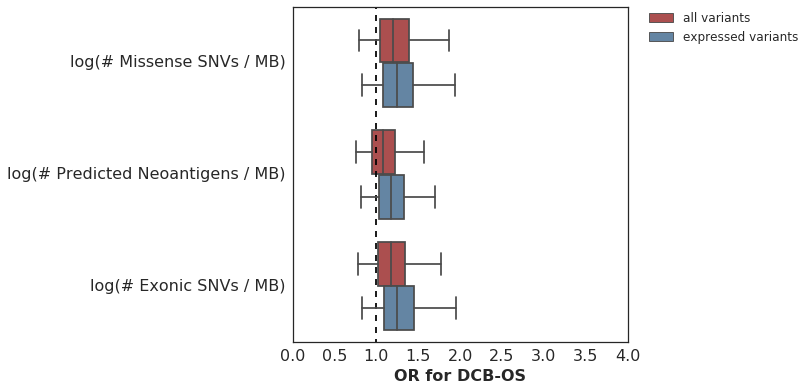

In [42]:
print('{{{coefplot-dcb-os}}}')
coefdata = univariate_coefplot(univariate_logit_models_os,
                               metrics=['missense_snv_count','exonic_snv_count','neoantigen_count'])
_ = plt.yticks([0, 1, 2],
               ['log(# Missense SNVs / MB)',
                'log(# Predicted Neoantigens / MB)',
                'log(# Exonic SNVs / MB)',
               ])
_ = plt.ylabel('')
_ = plt.xlabel('OR for {}'.format(cohort.benefit_os_plot_name))

{{{coefplot-ratios-dcb-os}}}


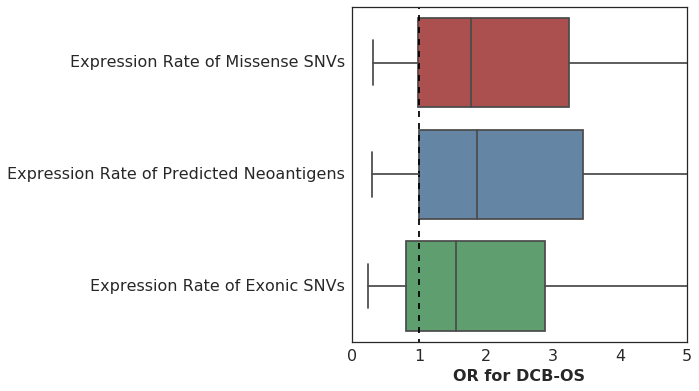

In [43]:
## look at expression ratios, separately
print('{{{coefplot-ratios-dcb-os}}}')

coefdata = univariate_coefplot(univariate_logit_models_os,
                               metrics=[x for x in extra_cols if 'expression_ratio' in x],
                               hue=None)
_ = plt.xlim([0, 5])
_ = plt.yticks([0, 1, 2],
               ['Expression Rate of Missense SNVs',
                'Expression Rate of Predicted Neoantigens',
                'Expression Rate of Exonic SNVs',
                 ])
_ = plt.ylabel('')
_ = plt.xlabel('OR for {}'.format(cohort.benefit_os_plot_name))

In [44]:
univariate_logit_os_coefdata = extract_univariate_coefdata(univariate_logit_models_os,
                                                 metrics=['missense_snv_count','exonic_snv_count','neoantigen_count']
                                                 )


coefdata_logit_os_grouped = univariate_logit_os_coefdata.groupby('metric')
for name, group in coefdata_logit_os_grouped:
    hyper_label='compare_%s_logit_os' % name
    paper.hyper_label_printer(label=hyper_label, formatter=paper.compare_posterior_dist, df=group, stat='OR')

{{{compare_exonic_snv_count_logit_os:median OR of 1.25 vs. 1.17 for expressed versus total}}}
{{{compare_missense_snv_count_logit_os:median OR of 1.25 vs. 1.20 for expressed versus total}}}
{{{compare_neoantigen_count_logit_os:median OR of 1.17 vs. 1.08 for expressed versus total}}}
